In [1]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
dataset = FashionMNIST(root='/home/anmol/Programming/python/Deep Learning/',
                       #download=True,
                       transform=transforms.Compose(
                           [transforms.ToTensor(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            #transforms.RandomCrop((25,25))
                           ]))

In [3]:
test_dataset = FashionMNIST(root='/home/anmol/Programming/python/Deep Learning/',
                            train=False,
                            transform=transforms.Compose(
                                [transforms.ToTensor(),
                                ]))

In [4]:
val_size = 10000
train_size = len(dataset)-val_size
test_size = len(test_dataset)
print(val_size,test_size,train_size)
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

10000 10000 50000


In [5]:
batch_size = 128
train_loader = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


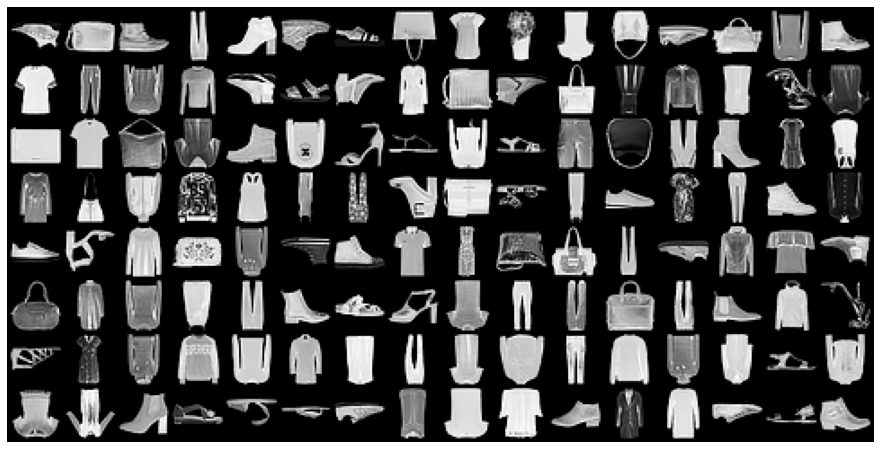

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Model

In [7]:
def accuracy(outputs,labels):
    _ ,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item() /len(labels))

In [28]:
# choosing activation functions refer to the following link 
#https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
class FashionMNIST(nn.Module):
    def __init__(self,in_size,out_size):
        super().__init__()
        # hidden layer 1
        self.layer1 = nn.Linear(in_size,64)
        # hidden layer 2
        self.layer2 = nn.Linear(64,128)
        # hidden layer 3
        self.layer3 = nn.Linear(128,64)
        # output layer
        self.layer4 = nn.Linear(64,out_size)
        
    def forward(self,xb):
        out = xb.view(xb.size(0),-1)
        out = self.layer1(out)
        out = torch.relu(out)
        out = self.layer2(out)
        out = torch.relu(out)
        out = self.layer3(out)
        out = torch.relu(out)
        out = self.layer4(out)
        #print('before softmax',out)
        #out = torch.softmax(out,dim=0)
        #print('after applying softmax',out)
        return out
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch #labels are from 0-9
        out = self(images)
        loss = F.cross_entropyoss_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss' : loss, 'val_acc' : acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self,epoch,results):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, results['val_loss'], results['val_acc']))

# GPU 

In [29]:
torch.cuda.is_available()

True

In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [33]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [35]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adagrad):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
input_size = 784
num_classes = 10
model = FashionMNIST(input_size, out_size=num_classes)
to_device(model, device)

FashionMNIST(
  (layer1): Linear(in_features=784, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [37]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.303239107131958, 'val_acc': 0.10878906399011612}]

In [38]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6870, val_acc: 0.7382
Epoch [1], val_loss: 0.5825, val_acc: 0.7852
Epoch [2], val_loss: 0.5607, val_acc: 0.7931
Epoch [3], val_loss: 0.5445, val_acc: 0.8013
Epoch [4], val_loss: 0.5632, val_acc: 0.7919
Epoch [5], val_loss: 0.4998, val_acc: 0.8151
Epoch [6], val_loss: 0.4934, val_acc: 0.8132
Epoch [7], val_loss: 0.4845, val_acc: 0.8244
Epoch [8], val_loss: 0.4815, val_acc: 0.8207
Epoch [9], val_loss: 0.4749, val_acc: 0.8282


In [39]:
history += fit(10, 0.03, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4746, val_acc: 0.8222
Epoch [1], val_loss: 0.4714, val_acc: 0.8268
Epoch [2], val_loss: 0.4545, val_acc: 0.8313
Epoch [3], val_loss: 0.4521, val_acc: 0.8357
Epoch [4], val_loss: 0.4501, val_acc: 0.8352
Epoch [5], val_loss: 0.4452, val_acc: 0.8351
Epoch [6], val_loss: 0.4461, val_acc: 0.8383
Epoch [7], val_loss: 0.4369, val_acc: 0.8387
Epoch [8], val_loss: 0.4325, val_acc: 0.8378
Epoch [9], val_loss: 0.4344, val_acc: 0.8368


In [20]:
history += fit(25, 0.004, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4385, val_acc: 0.8373
Epoch [1], val_loss: 0.4403, val_acc: 0.8381
Epoch [2], val_loss: 0.4372, val_acc: 0.8389
Epoch [3], val_loss: 0.4359, val_acc: 0.8422
Epoch [4], val_loss: 0.4333, val_acc: 0.8411
Epoch [5], val_loss: 0.4377, val_acc: 0.8404
Epoch [6], val_loss: 0.4370, val_acc: 0.8369
Epoch [7], val_loss: 0.4352, val_acc: 0.8392
Epoch [8], val_loss: 0.4323, val_acc: 0.8438
Epoch [9], val_loss: 0.4349, val_acc: 0.8416
Epoch [10], val_loss: 0.4330, val_acc: 0.8445
Epoch [11], val_loss: 0.4350, val_acc: 0.8434
Epoch [12], val_loss: 0.4326, val_acc: 0.8441
Epoch [13], val_loss: 0.4333, val_acc: 0.8401
Epoch [14], val_loss: 0.4335, val_acc: 0.8454
Epoch [15], val_loss: 0.4378, val_acc: 0.8395
Epoch [16], val_loss: 0.4316, val_acc: 0.8445
Epoch [17], val_loss: 0.4328, val_acc: 0.8402
Epoch [18], val_loss: 0.4358, val_acc: 0.8430
Epoch [19], val_loss: 0.4268, val_acc: 0.8461
Epoch [20], val_loss: 0.4327, val_acc: 0.8424
Epoch [21], val_loss: 0.4321, val_acc: 0.840

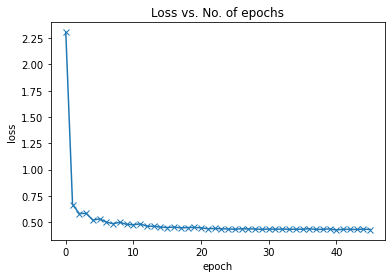

In [21]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

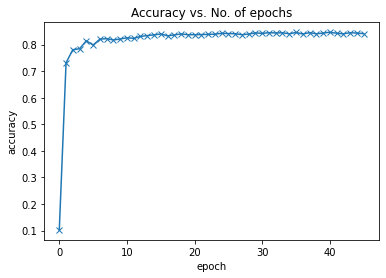

In [22]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Prediction on Samples

In [23]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Trouser , Predicted: Trouser


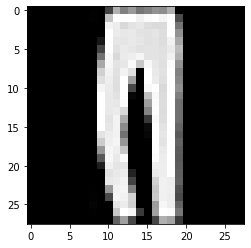

In [24]:
img, label = test_dataset[2]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [25]:
evaluate(model, test_loader)

{'val_loss': 0.4464170038700104, 'val_acc': 0.836132824420929}

In [26]:
torch.save(model.state_dict(),'fashion-mnist.pth')